In [1]:
pip install -q datasets

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -q transformers

Note: you may need to restart the kernel to use updated packages.


In [144]:
import torch
from torch.utils.data import Dataset
from datasets import load_dataset
from transformers import AutoTokenizer, Trainer
from transformers import EvalPrediction
from transformers import TrainingArguments

from huggingface_hub import hf_hub_download


from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import precision_recall_curve 

from scipy.stats import spearmanr

import pandas as pd
import numpy as np
import json
import re
import tqdm

In [8]:
# the transformer model
from affinity_pred.model import EnsembleSequenceRegressor

**Load tokenizers**

In [9]:
seq_model_name = "Rostlab/prot_bert_bfd"
seq_tokenizer = AutoTokenizer.from_pretrained(seq_model_name, do_lower_case=False)

In [10]:
smiles_model_name = 'mossaic-candle/regex-gb-2021'
smiles_tokenizer =  AutoTokenizer.from_pretrained(smiles_model_name)

In [11]:
def expand_seqs(seqs):
    input_fixed = ["".join(seq.split()) for seq in seqs]
    input_fixed = [re.sub(r"[UZOB]", "X", seq) for seq in input_fixed]
    return [list(seq) for seq in input_fixed]

In [66]:
# on-the-fly tokenization

# the maximum length of a protein seqeuence (for inference)
max_seq_length=512

# the maximum length of a SMILES sequence
max_smiles_length=256

def encode(item):
        seq_encodings = seq_tokenizer(expand_seqs(item['seq'])[0],
                                      truncation=True,
                                      padding='max_length',
                                      max_length=max_seq_length,
                                      is_split_into_words=True)
        
        # use RDkit canonical SMILES        
        if 'smiles_can' in item:
            smiles = item['smiles_can'][0]
        else:
            smiles = item['smiles'][0]
            
        smiles_encodings = smiles_tokenizer(smiles,
                                            padding='max_length',
                                            truncation=True,
                                            max_length=max_smiles_length)
        
        # concatenate the two different inputs
        item['input_ids'] = [torch.cat([torch.tensor(seq_encodings['input_ids']),
                                        torch.tensor(smiles_encodings['input_ids'])])]
        item['attention_mask'] = [torch.cat([torch.tensor(seq_encodings['attention_mask']),
                                        torch.tensor(smiles_encodings['attention_mask'])])]
        return item

In [13]:
class AffinityDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, idx):
        item = self.dataset[idx]
        
        #affinity = item['neg_log10_affinity_M']
        affinity = item['affinity']
        item['labels'] = float(affinity)
        
        # drop the non-encoded input
        item.pop('smiles')
        item.pop('smiles_can')
        item.pop('seq')
        item.pop('neg_log10_affinity_M')
        item.pop('affinity_uM')
        item.pop('affinity')
        return item

    def __len__(self):
        return len(self.dataset)

**Load model**

In [258]:
def model_init():
    model = EnsembleSequenceRegressor(seq_model_name, smiles_model_name, max_seq_length=max_seq_length)

    # select one of the following ensemble members
    model_name = 'regex_1'
    #model_name = 'regex_2'
    #model_name = 'regex_3'
    #model_name = 'regex_4'
    #model_name = 'regex_5'

    # download the weights
    fn = hf_hub_download(repo_id="jglaser/affinity_pred_{}".format(model_name), filename='pytorch_model.bin')
    checkpoint = torch.load(fn)
    model.load_state_dict(checkpoint)
    return model

In [259]:
def compute_metrics(p: EvalPrediction):
    preds_list, out_label_list = p.predictions, p.label_ids

    return {
        "mse": mean_squared_error(out_label_list, preds_list),
        "mae": mean_absolute_error(out_label_list, preds_list),
        "spearman_rho": spearmanr(out_label_list, preds_list).correlation,
    }

In [260]:
trainer = Trainer(
    model_init=model_init,                # the instantiated Transformers model to be trained
    compute_metrics = compute_metrics,    # evaluation metric
    args=TrainingArguments(per_device_eval_batch_size=32, # reduce if running out of memory
                           output_dir='results'),
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file config.json from cache at /ccs/home/glaser/.cache/huggingface/hub/models--Rostlab--prot_bert_bfd/snapshots/6c5c8a55a52ff08a664dfd584aa1773f125a0487/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 40000,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 30,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1"

**Test dataset**

In [261]:
data_all = load_dataset("jglaser/binding_affinity",split='train')
split = data_all.train_test_split(train_size=1000)
test = split['train']
test.set_transform(encode)

Using custom data configuration default
Found cached dataset binding_affinity (/ccs/home/glaser/.cache/huggingface/datasets/jglaser___binding_affinity/default/1.4.1/caf1a3e2b3eb66a5ee7b44fa9b039ae9188b949c6da91d8077998f347883556c)
Loading cached split indices for dataset at /ccs/home/glaser/.cache/huggingface/datasets/jglaser___binding_affinity/default/1.4.1/caf1a3e2b3eb66a5ee7b44fa9b039ae9188b949c6da91d8077998f347883556c/cache-96bf30ab2789dc77.arrow and /ccs/home/glaser/.cache/huggingface/datasets/jglaser___binding_affinity/default/1.4.1/caf1a3e2b3eb66a5ee7b44fa9b039ae9188b949c6da91d8077998f347883556c/cache-469e7b6501c0cf9a.arrow


In [262]:
test_dataset = AffinityDataset(test)

In [263]:
y = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 1000
  Batch size = 32
/opt/conda/lib/python3.8/site-packages/transformers/modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [264]:
# un-normalize predictions [to -log_10 affinity[M] units]
field_log10 = 'neg_log10_affinity_M'
mean, var = (np.mean(data_all[field_log10]), np.var(data_all[field_log10]))
def scale(x):
    return x*np.sqrt(var)+mean

In [265]:
y.metrics['test_mse'] * var

0.7666611496707437

In [266]:
y.metrics['test_spearman_rho']

0.8694019495450057

**PostEra Mpro dataset**

In [267]:
# SARS-CoV main protease
mpro_seq_5r84 = "SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ"

In [268]:
len(mpro_seq_5r84)

306

In [269]:
class PosteraDataset(Dataset):
    def __init__(self, df, mean, var, seq):
        self.df = df
        self.mean = mean
        self.var = var
        self.seq = seq
        
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        item = {'smiles': [row.SMILES], 'seq': [self.seq]}
        item = encode(item)
        
        # get first (single) item
        item['input_ids'] = item['input_ids'][0]
        item['attention_mask'] = item['attention_mask'][0]
        
        affinity = 6-np.log(row['f_avg_IC50'])/np.log(10)
        affinity = (affinity-self.mean)/np.sqrt(self.var)
        item['labels'] = float(affinity)
        
        # drop the non-encoded input
        item.pop('smiles')
        item.pop('seq')
        return item

    def __len__(self):
        return len(self.df)

In [270]:
df = pd.read_csv('data/activity_data.csv')
df = df[~df['f_avg_IC50'].isnull()].reset_index(drop=True)

In [271]:
postera_dataset = PosteraDataset(df=df, mean=mean, var=var, seq=mpro_seq_5r84)

In [272]:
len(postera_dataset)

1926

In [273]:
y=trainer.predict(postera_dataset)

***** Running Prediction *****
  Num examples = 1926
  Batch size = 32
/opt/conda/lib/python3.8/site-packages/transformers/modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [274]:
y.metrics['test_mse'] * var

2.2970302078307046

In [275]:
y.metrics['test_spearman_rho']

0.5171505864721267

In [276]:
df['prediction'] = scale(y.predictions)

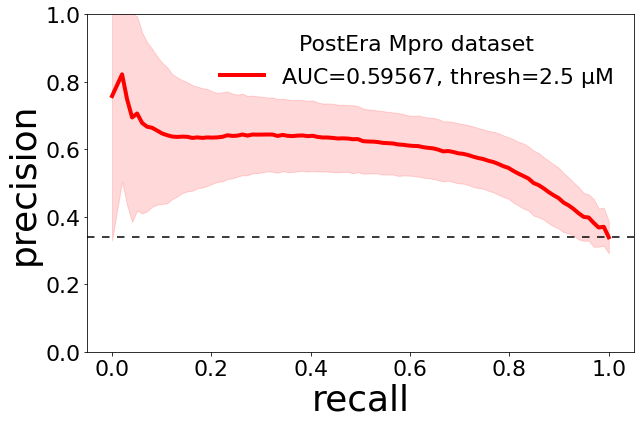

In [278]:
import matplotlib.pyplot as plt

thresh = 2.5 # the activity threshold in uM below which a ground truth sample is considered 'active'
nbootstrap = 500
samplesize = 100
x = np.linspace(0,1,100)

ps = []
for i in range(nbootstrap):
    df_sample = df.sample(n=samplesize,replace=True)
    yr = df_sample.f_avg_IC50 < thresh
    #yr = df_sample.f_inhibition_at_20_uM > thresh
    p, r, _ = precision_recall_curve(yr, df_sample.prediction)
    ps.append(np.interp(x,r[::-1],p[::-1]))
    
ps = np.vstack(ps)
pavg = np.mean(ps,axis=0)
perr = np.std(ps,axis=0)
auc = np.trapz(pavg[::-1],x)
alpha_err = 0.15
fig, ax = plt.subplots()
fig.set_size_inches(9,6)

ax.plot(x, pavg, label='AUC={:.5f}, thresh={} $\\mathrm{{\\mu M}}$'.format(auc,thresh),color='r',lw=4)
ax.fill_between(x, pavg - perr, pavg + perr, color='r', alpha=alpha_err)

ax.axhline(pavg[-1], dashes=[5.0,5.0], color='k')

ax.set_ylim(0,1)

ax.set_xlabel('recall',fontsize=36)
ax.set_ylabel('precision',fontsize=36)
ax.set_ylim(0,1)
ax.tick_params(labelsize=22)
l = ax.legend(frameon=False,title='PostEra Mpro dataset',fontsize=22)
l.get_title().set_fontsize(22)

fig.tight_layout()
#fig.savefig('postera_pr_{:.2f}.png'.format(thresh))